<a href="https://colab.research.google.com/github/joseluisfalla/DSPS_JFalla/blob/main/HW5/HW5_FitLineToGRBAfterGlow_mcmc_JFalla_DSPS23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

# Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [2]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/main/data/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


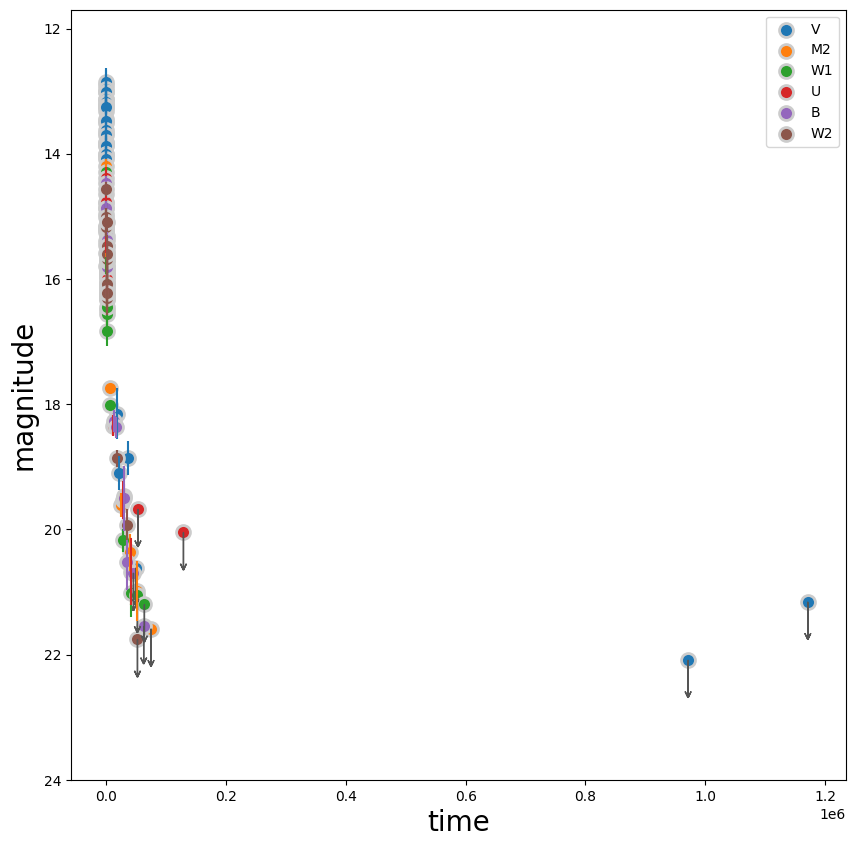

In [3]:
#create a figure container and an axis object inside of it
ax = plt.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    plt.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    plt.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    plt.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
plt.ylim(24,11.7)
plt.legend()

#Always rememebr you axis labels!!
plt.ylabel("magnitude", fontsize=20)
plt.xlabel("time", fontsize=20);

# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [4]:
grbAG['logtime'] = np.log10(grbAG['time'])
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

In [5]:
def plotlogtime(df, models=[]):
  #create a figure container and an axis object inside of it
  ax = plt.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG["filter"].unique():
    plt.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG["filter"].unique():
    plt.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows
  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    plt.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  plt.ylim(24,11.7)
  plt.legend()

  #Always rememebr you axis labels!!
  plt.ylabel("magnitude", fontsize=20)
  plt.xlabel("log time", fontsize=20)
  return ax

<Axes: xlabel='log time', ylabel='magnitude'>

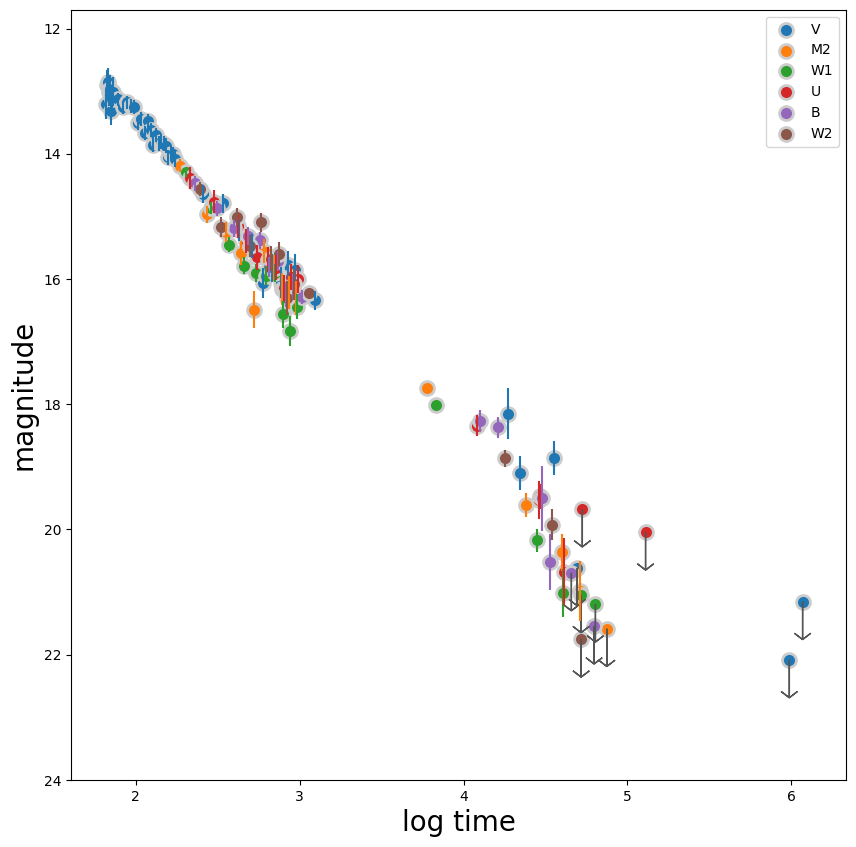

In [6]:
plotlogtime(grbAG)

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

# Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [7]:
x = grbAG[grbAG.upperlimit == 0].logtime.values
X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)),
          x]


y = grbAG.loc[grbAG.upperlimit == 0].mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [8]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " +
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```.
To remove the upper limits you can "broadcast" the data: in pandas that looks like

```grbAG.loc[grbAG.upperlimit == 0]```



In [9]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
lr = LinearRegression()
lr.fit(X, y)
lr.coef_, lr.intercept_

(array([0.        , 2.51199984]), 8.582668233648771)

In [10]:
print(f'Best fit parameters from SKLearn are intercept {lr.intercept_:.2f} and slope {lr.coef_[1]:.2f}')

Best fit parameters from SKLearn are intercept 8.58 and slope 2.51


# Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 and L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [11]:
def line(intercept, slope, x):
    return intercept + slope * x

In [12]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize

def line(intercept, slope, x):

    return slope * x + intercept

def l1(args, x, y):

    intercept, slope = args

    return sum(np.abs(y - line(intercept, slope, x)))

def l2(args, x, y):

  intercept, slope = args

  return sum((y - line(intercept, slope, x))**2)

initialGuess = (10, 1)

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 26.303314072819276
        x: [ 8.225e+00  2.641e+00]
      nit: 20
      jac: [ 0.000e+00 -7.153e-07]
 hess_inv: [[ 2.576e-07 -1.766e-08]
            [-1.766e-08  5.461e-09]]
     nfev: 180
     njev: 60

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64


In [13]:

def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    intercept, slope = args

    return sum((y - line(intercept, slope, x))**2)

initialGuess = (10, 1)

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " +
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.825987500725516
        x: [ 8.583e+00  2.512e+00]
      nit: 4
      jac: [-4.768e-07 -4.768e-07]
 hess_inv: [[ 6.254e-02 -2.030e-02]
            [-2.030e-02  7.114e-03]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of L2: slope 8.58, intercept 2.51



# Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [14]:
def chi2(args, x, y, yerr):

  intercept, slope = args

  return sum((y - line(intercept, slope, x))**2 / yerr**2)

x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values

initialGuess = (10, 2)

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 317.42066980130846
        x: [ 8.599e+00  2.480e+00]
      nit: 5
      jac: [ 0.000e+00  1.144e-05]
 hess_inv: [[ 3.348e-04 -6.121e-05]
            [-6.121e-05  1.227e-05]]
     nfev: 27
     njev: 9

best fit parameters from the minimization of the chi squared: slope 8.60, intercept 2.48


# Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


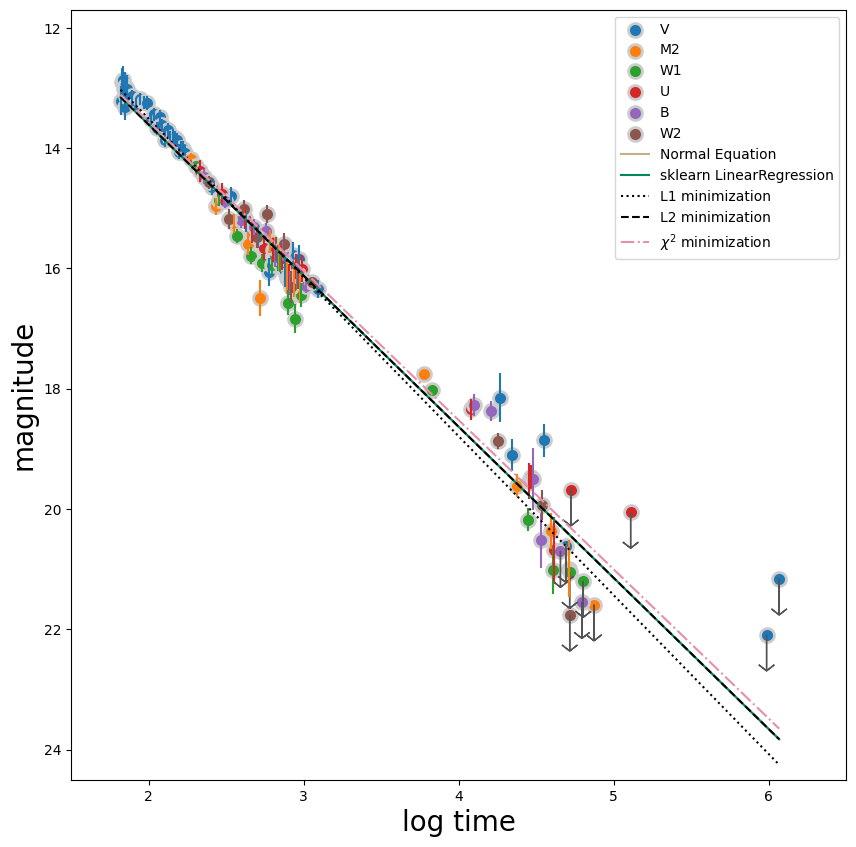

In [15]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

plt.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

plt.ylim(24.5,11.7)
plt.xlim(1.5, 6.5)
plt.ylabel("magnitude", fontsize=20)
plt.xlabel("log time", fontsize=20);


Figure 2: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.

# HW part 1: redo the sklearn model with a train-test split of the data

- choose the train-test rations that you prefer
- get the score for the model when predicting on the train data and on the test data
- what can you say about the model by comparing the two scores?

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [17]:
reg = LinearRegression()
reg.fit(x_train, y_train)

print(f'R^2 on training set: {reg.score(x_train, y_train):.3f}.' + '\n' + f'R^2 of test set: {reg.score(x_test, y_test):.3f}.')

R^2 on training set: 0.972.
R^2 of test set: 0.970.


These two scores are very close to one another. This tells us that a linear regression gives a good fit (model) to the data.

# Now try a line to the data with MCMC

# HW part 2: write captions for each figure. The figures are produced by my code. The captions should state:
- what is plotted
- what is noticeable or interesting in the figure



In [18]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.0 MB/s eta 0:00:00


In [19]:
import emcee #import the package

In [20]:
emcee

<module 'emcee' from '/usr/local/lib/python3.10/dist-packages/emcee/__init__.py'>

look at documentation: https://emcee.readthedocs.io/en/stable/

We are implementing Bayes theorem to find the best model parameters: $P(\theta | D) ~ P(D | \theta) * P(\theta)$ or _Posterior ~ Likelihood * Prior_

Since we are maximizing the likelihood, we work in log space because:
- the logarithm is a monotonic function of its argument (meaning where the argument gets bigger its log gets bigger, where it gets smaller its log gets smaller)
- the log is not defined for negative values (log(something < 0) is undefined) but this does not matter because the likelihood is a probability and probabilities are positive defined.



In [21]:
# LINE MODEL
def log_prior(theta):
  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0
  #semi informative prior: i know light has to get fainter (mag get bigger)
  #i know i dont use negative mags
  return -np.inf


In [22]:
#log likelihood
def log_likelihood(theta, x, y, yerr):
  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -np.sum(((y - line(intercept, slope, x))**2) / yerr**2)

In [23]:
#log posterior
def log_posterior(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood(theta, x, y, yerr)

In [24]:
#initial guess
ig = [1,10]

In [25]:
#initialize N walkers
nwalkers = 32
ndim = len(ig)

In [26]:
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim) #the starting point for each walker is a small perturbation of the initial guess

In [27]:
pos.shape

(32, 2)

In [28]:
# this sets up the model and assignes the hyperparameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, s))

In [29]:
# this runs the MCMC for 5,000 steps
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:16<00:00, 310.93it/s]


In [30]:
# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

In [31]:
samples.shape

(5000, 32, 2)

In [32]:
# to get statistical properties of the chains I will concatenate the 32 chains. This works _iff_ the chains are independent
# note: the chains are _assumed_ to be independent
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [33]:
#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
mcmc

array([[2.46552191, 2.47961404, 2.49393808],
       [8.56101933, 8.60055666, 8.63964419]])

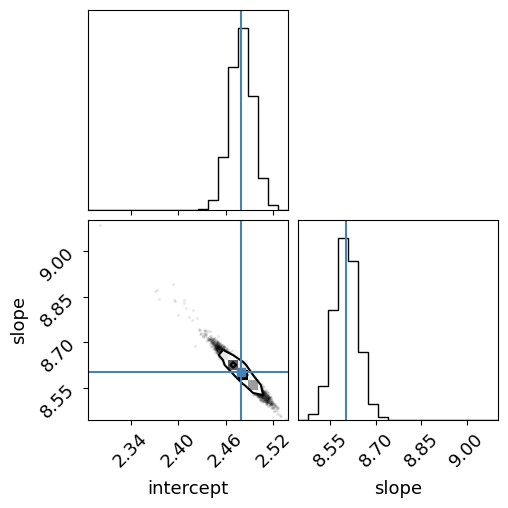

In [34]:
#plotting the likelihood space: the panels are 2D projections of the feature space and 1D marginalized probabilities for each parameters
!pip install corner
import corner
plt.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["intercept", "slope"], truths=mcmc[:,1]);


Figure 3. Histograms of intercept and slope Markov chain values (top left and bottom right, respectively). Both parameters follow a Gaussian distribution. The bottom left panel shows that there is a correlation between the these parameters.

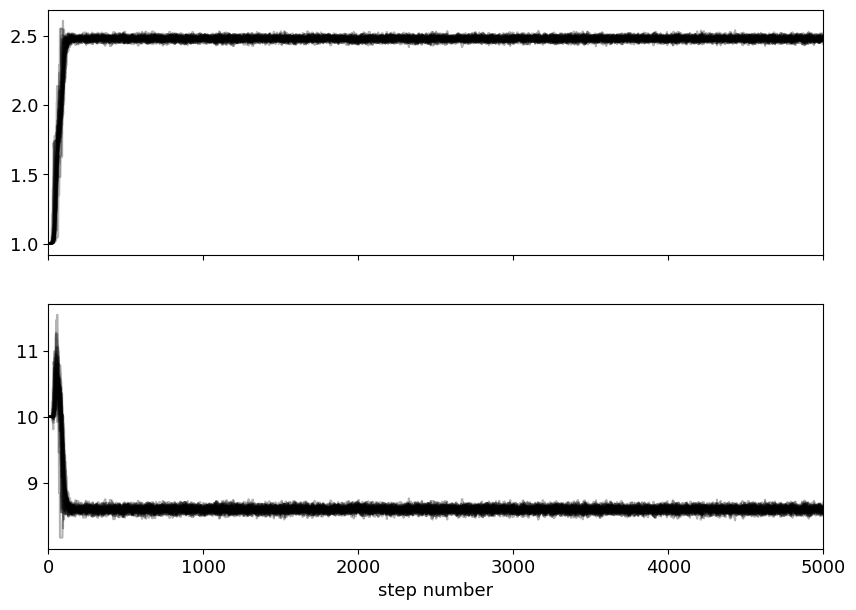

In [35]:
# the chains should be plotted as well. in the slides and in class I discuss what you should expect them to look like
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 4. Markov chains as a function of step number for the a linear fit of the data. Very quickly the both the values for the intercept and the slope converge close to the "true" value.

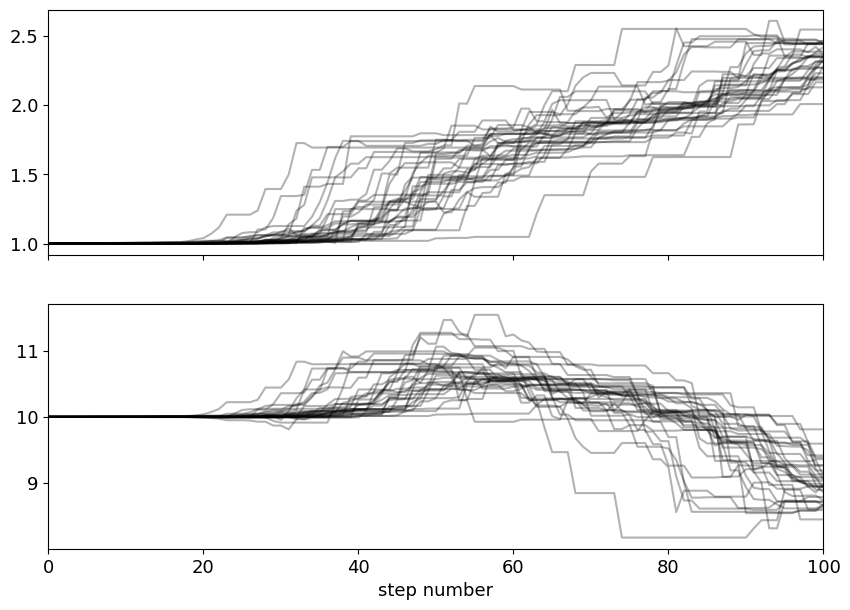

In [36]:
# zoom in: the beginnign of the chane should be cut - this is the burn-in part of the chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 5. Zoomed in section of Figure 4. Here we see how Markov chain initially diverge, but after ~100 steps converge to the "true" value.

In [37]:
# save the mcmc results for later
mcmc_line = mcmc

In [38]:
def bpl (theta, x):
    """broken power law model
    Input:
      theta: (array like) 4 parameters vector, see equation
      x: (array like) independent variable
    Return:
      model predictions for each x (array like)
    """

    t_b, a_1, a_2, b = theta

    tmp = (x / t_b)

    f = (tmp**(-a_1) + tmp**(-a_2))

    return b - np.log10(f)

# HW part 3

# Now try a broken power law (BPL) model

A power la is not a good model for GRB afterglows. A broken power law has been known to be a better model and has several physical motivations. In this exercise you will fit a _broke power law_ to the data, which is a more complex and higher dimensional model than the simple line fit we did so far, with MCMC getting best values for the posterior, a complete characterization of the likelihood, and allowing model selection between the line and the power law.

> Here is some info that talks about the power law model and the phsyics of GRB, which you need not know to solve the assignment but you may be interested in.  A broken power law is a power law ($y ~ x^a$) where the power a changes at some point. This can be caused by the presence of two power law processes with different, for example, where one dominates at early time and the other at late times.


>> Here is some more info that explains why we observed the GRB afterglows as broken power laws.
>>Gamma-ray bursts (GRBs) are produced by the collapse of massive stars or the merger of compact objects like neutron stars. The energy of the collapse is highly energetic (Gamma rays) but the emission gets reprocessed as it leaves the system and looses energy becoming detectable in the optical wavelengths. This is called the "optical afterglow of the GRB".
>>The explosion resulting from the collapse generates a highly relativistic outflow of material that moves at a significant fraction of the speed of light.
>> The afterglow emission is primarily produced through synchrotron radiation, where charged particles spiral around magnetic field lines. The radiation produced by synchrotrone follows a power law with an index that depends on the density of the surrounding medium, the Lorentz factor of the outflow, and the magnetic field strength. As the radiation crosses different regions of the system that collapsed these factors change and the powerlaw index changes with them.

>>If the relativistic outflow is highly collimated (a jet) as the jet expands, its emission can be modeled as a power-law light curve, but  where the jet begins to decelerate and spread out the slope of the power law changes. This transition is known as the "jet break" and results in a broken power-law behavior.

>> Some GRBs exhibit late-time flares or additional energy injection from the central engine but we are not modeling this in this exercise.




_BPL model variables:_

$F = \mathrm{flux}$ - note: not magnitude this time! $mag ~ -2.5log10(Flux)$

$t =  \mathrm{time}$ - note: not log time

_BPL model parameters:_


$T_b =  \mathrm{Time~of~break}$

$a_1:  \mathrm{Early~slope}$

$a_2: \mathrm{Late~slope}$

$b:  \mathrm{nuisance~parameters}$

_BPL model_:

$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$


$b - log_{10}((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2}) $



In [39]:
t = grbAG[grbAG.upperlimit == 0].time.values

In [40]:
t.min(), t.max()

(66, 51257)

# HW part 3 task 1:
create the model `bpl()`, the `log_likelihood()`, `log_prior()` (choose what you want to set your prior to), and `log_posterior()`

In [41]:
def bpl (theta, x):
    """broken power law model
    Input:
      theta: (array like) 4 parameters vector, see equation
      x: (array like) independent variable
    Return:
      model predictions for each x (array like)
    """

    t_b, a_1, a_2, b = theta

    tmp = (x / t_b)

    f = (tmp**(-a_1) + tmp**(-a_2))

    return b - np.log10(f)


In [42]:
def log_likelihood_bpl(theta, x, y, yerr):
    # use the same log_likelihood as before (chi2) but with the new model
    model = bpl(theta, x)

    return -0.5 * sum((y - model)**2 / yerr**2)

def log_prior_bpl(theta):

  t_b, a_1, a_2, b = theta
  if (0 < t_b < 100000) and (-10 < a_1 < 10) and (-10 < a_2 < 10) and (-10000 < b < 10000):
    return 0

  return -np.inf


def log_posterior_bpl(theta, x, y, yerr):

  log_prior = log_prior_bpl(theta)

  if not np.isfinite(log_prior):
    return -np.inf

  return log_prior + log_likelihood_bpl(theta, x, y, yerr)

# HW part 3 task 2:
Find the initial starting point as a stochastic gradient descent minimization of the log likelihood

In [43]:
def neg_log_likelihood_bpl(theta, x, y, y_err):
    return -log_likelihood_bpl(theta, x, y, y_err)

ig = [0.2, 5, 1000, 20]
bounds = [(66, 51257), (-10, 10), (-10, 10), (-1000, 1000)]
soln = minimize(neg_log_likelihood_bpl, ig, args=(t, y, s), bounds=bounds)
soln

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 108.73265746421339
        x: [ 2.736e+02  2.146e+00  3.548e+00  1.505e+01]
      nit: 50
      jac: [-1.251e-04  5.187e-03  4.917e-04  3.073e-02]
     nfev: 340
     njev: 68
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

Text(0, 0.5, 'magnitude')

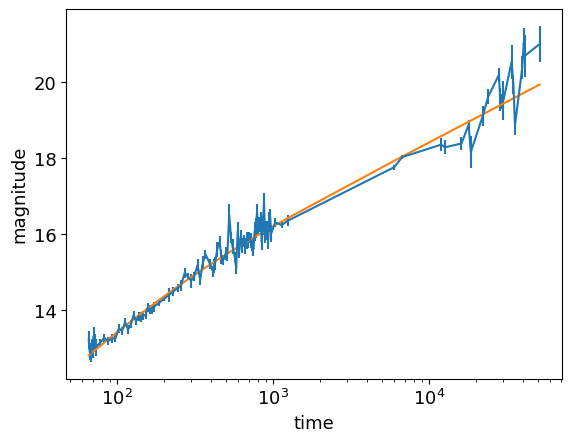

In [44]:
ig = soln.x # the initial guess for the MCMC

# plot the model as it looks with the initial guess values
plt.errorbar(t, y, yerr=s)
plt.plot(t, bpl(ig, t))
plt.xscale("log")
plt.xlabel('time')
plt.ylabel('magnitude')

Figure 6. Stochastic gradient descent minimization of log likelihood to obtain parameters of BPL model fit to the data. We will use these values as our initial guess in the MCMC optimization.

# HW 3 task 3: optimize the model wit MCMC

- set the emcee hyperparameters
- run the chains
- extract the statistical properties of the chain as the best fit values
- plot the model
- plot the marginalized posteriors of the model parameters

In [45]:
# set the emcee hyperparameters
nwalkers, ndim = 32, len(ig)
pos = ig + 1e-2 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_bpl, args=(t, y, s))

In [46]:
# run the model
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:28<00:00, 174.55it/s]


State([[195.70450866   2.18508799   3.55138226  14.63966306]
 [181.66072564   2.19928678   3.79015466  14.57802768]
 [387.59410674   2.08928473   3.4247805   15.4477922 ]
 [233.43700125   2.20591273   3.50959535  14.84329786]
 [369.02619671   2.1202154    3.41663157  15.40840265]
 [432.43188012   2.04230182   3.26936221  15.57280621]
 [282.20945999   2.1642704    3.45510639  15.05315482]
 [254.17192633   2.1682938    3.59404523  14.95953025]
 [286.56154062   2.1428656    3.49030647  15.13307324]
 [381.0191909    2.10257503   3.34642381  15.46082977]
 [205.71401229   2.18054247   3.62991165  14.6847092 ]
 [246.7215794    2.11867195   3.54178629  14.9263105 ]
 [403.13001643   2.07325382   3.35696325  15.50331486]
 [357.31454131   2.10954164   3.3832448   15.36501599]
 [330.22139082   2.10625342   3.42213486  15.28141442]
 [251.18772999   2.21753856   3.53958907  14.92108608]
 [465.96163134   2.04016193   3.29624829  15.67651764]
 [245.0972459    2.19054747   3.60726167  14.89357717]
 [41

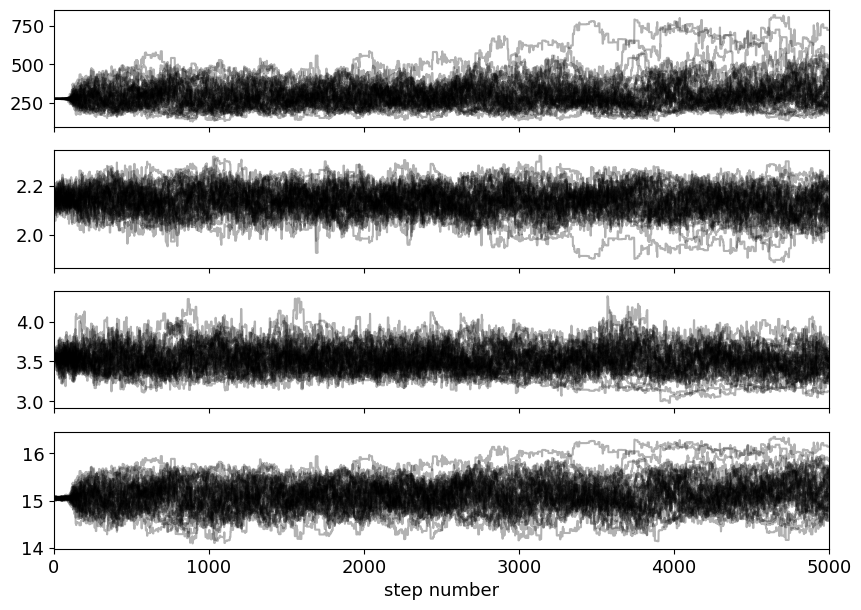

In [47]:
#plot the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

Figure 7. Markov chains for the parameters in the broken power law. From top to bottom: time of break, early slope, late slope, and nuisance parameter. We see that we start at a good point, so the chains remain around the same values.

In [48]:
# get the 16th, 50, and 84th percentiles of the model parameters
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
    mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
mcmc

array([[219.00997416, 287.33869958, 388.48137605],
       [  2.07873898,   2.13785173,   2.19418007],
       [  3.35407064,   3.51537385,   3.69521145],
       [ 14.77324287,  15.10410557,  15.46401202]])

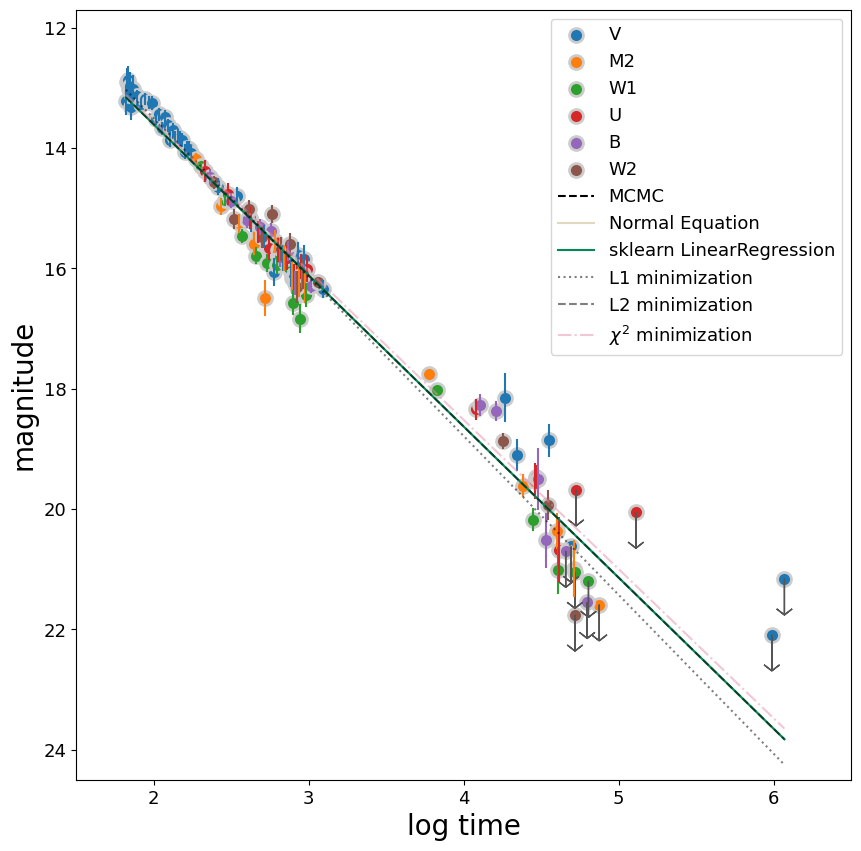

In [49]:
#plot the model
ax = plotlogtime(grbAG)

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(grbAG.logtime.values, line(mcmc[:,1][0], mcmc[:,1][1],
                            grbAG.logtime.values), ls="--", c="k", label="MCMC")
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],  alpha=0.5,
         label="Normal Equation", ax=ax)
#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':', alpha=0.5,
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--', alpha=0.5,
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.', alpha=0.5,
         label=r"$\chi^2$ minimization", ax=ax)

plt.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
plt.axvline(np.log10(mcmc[2,1]))
plt.ylim(24.5,11.7)
plt.xlim(1.5, 6.5)
plt.ylabel("magnitude", fontsize=20)
plt.xlabel("log time", fontsize=20);

Figure 8. Comparison of all fittings (like Figure 2), including the broken power law fitting.

## plot the marginalized posterior distributions of the parameters

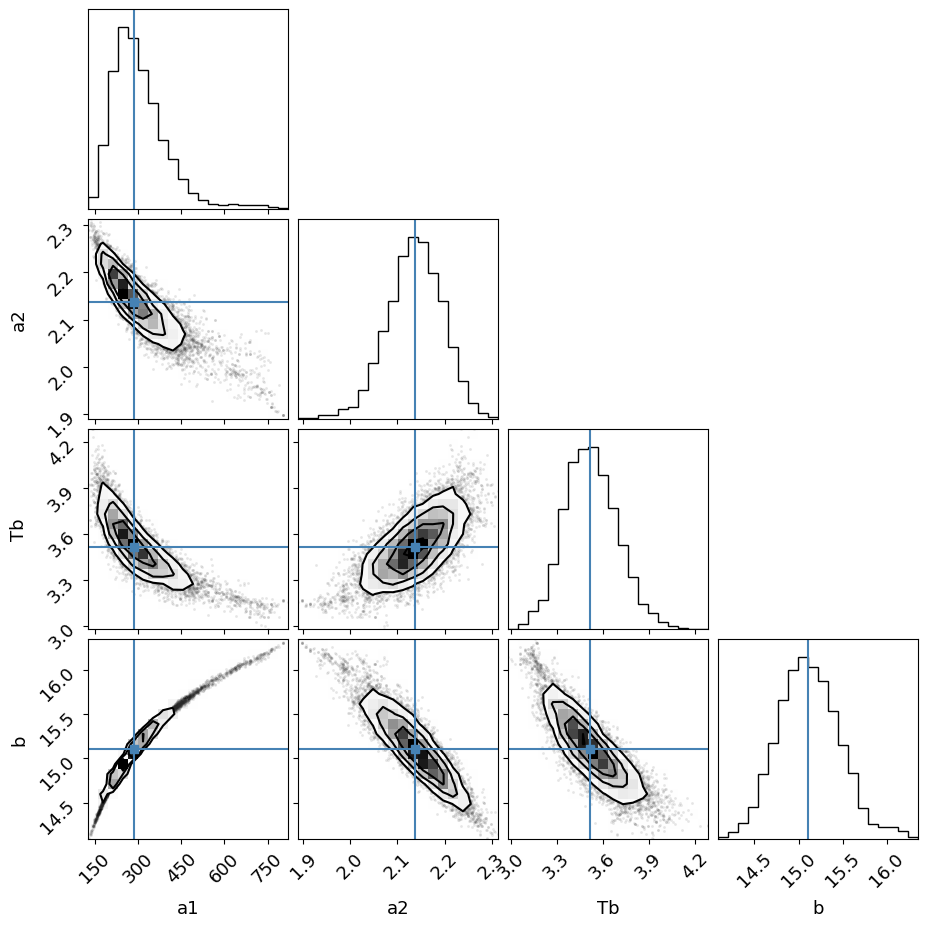

In [50]:

plt.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["a1", "a2", "Tb", "b"], truths=mcmc[:,1]);



Figure 9. Distributions of broken power law parameters. We see that there are pair-wise correlations for each of the parameters.

# HW part 4: Compare the line (as obtained by the MCMC) and broken power law models. For this part of the assignment use the slides in part 2.2 of the current slide deck (slide column 8) https://slides.com/federicabianco/dsps_6#/8. in particular:

- Print the loglikelihood of each model (you can use the log_likelihood function you had written for each)
https://slides.com/federicabianco/dsps_6#/8/1 through https://slides.com/federicabianco/dsps_6#/8/3

- implement the caluculation of the AIC (https://slides.com/federicabianco/dsps_6#/8/4 through 6)
- and BIC (https://slides.com/federicabianco/dsps_6#/8/7)



In [51]:
print(f"Log-likelihood of line model: {log_likelihood(mcmc_line[:,1], x, y, s):.2f}")

Log-likelihood of line model: -317.42


In [52]:
print(f"Log-likelihood of broken power-law model: {log_likelihood_bpl(mcmc[:,1], t, y, s):.2f}")

Log-likelihood of broken power-law model: -108.76


## Implement the likelihood ration test printing out the likelihood ration statistics

The likelihood-ratio test assesses the goodness of fit of two competing _nested_ statistical models based on the values of the likelihood $L$ where $M1$ is the restricted model (the parameter space is smaller, hence restricted), nested inside $M2$, the full model (the more complex one).

$ \lambda_\mathrm{LR}=-2\ln {\frac {L(M1(\theta_\mathrm{restricted}))}{L(M2(\theta_\mathrm{full}))}}$

This statistics is expexted to be $\chi2$ distributed following a $ch2$ distribution with d.o.f=difference in size of the parameter space in the two models (number of parameters in bpl model - number of parameters in line model).


In [53]:
def like_ratio_statistics(log_likelihood_min, log_likelihood_max):

  return -2 * (log_likelihood_min - log_likelihood_max)

statistics = like_ratio_statistics(log_likelihood(mcmc_line[:,1], x, y, s), log_likelihood_bpl(mcmc[:,1], t, y, s))

print("Likelihood Ratio Statistic: {:.4f}".format(statistics))

Likelihood Ratio Statistic: 417.3323


## Calculate the AIC and BIC: Aikiki Information Criterion and Bayesian Information Criterion for the comparison of the same two models.


In [54]:
def aic(x, l, k):

  return (2 / len(x)) * (k - l)


def bic(x, l, k):
  return np.log10(len(x)) * k - 2 * l


In [55]:
df = len(mcmc[:,1]) - len(mcmc_line[:,1])
print("AIC line {0:.2f} - AIC bpl {1:.2f}".format(aic(x, log_likelihood(mcmc_line[:,1], x, y, s), df),
                                      aic(x, log_likelihood_bpl(mcmc[:,1], t, y, s), 4)))

print("BIC line {0:.2f} - BIC bpl {0:.2f}".format(bic(x, log_likelihood(mcmc_line[:,1], x, y, s), df),
                                      bic(x, log_likelihood_bpl(mcmc[:,1], t, y, s), 4)))

AIC line 5.92 - AIC bpl 2.09
BIC line 638.91 - BIC bpl 638.91


# Extra Credit
 redefine the chi2 that I have written above to take a n deg polynomial, fit it to the data, compare it to the BPL model